In [14]:
import zipfile
from google.colab import drive

import warnings
warnings.filterwarnings('ignore')

In [15]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
local_zip = '/content/drive/MyDrive/MBA_data/deep_learning/iti-mlp-iml3-rnn.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [17]:
# SOURCE_DIR = r'../input/iti-mlp-iml3-cnn'
SOURCE_DIR = r'/tmp'

# Importando as bibliotecas

In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

import re
import nltk
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer

# Carregando os datasets

In [19]:
df = pd.read_csv(SOURCE_DIR + "/train.csv")

In [20]:
df.head()

,Id,title,text,subject,date,class
0,0,Trump defends tax plan as 'great Christmas gif...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"December 16, 2017",0
1,1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",Government News,"Sep 22, 2016",1
2,2,Trump rails against press in response to repor...,"FAIRFIELD, Conn. (Reuters) - U.S. Republican D...",politicsNews,"August 14, 2016",0
3,3,Republican Santorum drops out of White House r...,WASHINGTON (Reuters) - Rick Santorum withdrew ...,politicsNews,"February 4, 2016",0
4,4,Immigrants in Central Florida nervous about se...,"APOPKA, Fla. (Reuters) - With Hurricane Irma b...",worldnews,"September 9, 2017",0


# Dando uma olhada nos dados

In [58]:
# Check for any null values
df.isna().sum()

Id         0
title      0
text       0
subject    0
date       0
class      0
total      0
dtype: int64

# Análise Exploratória

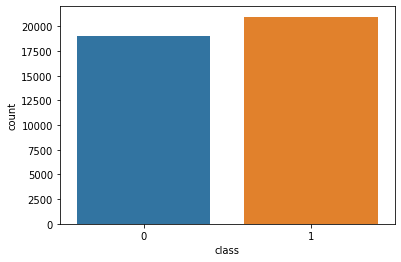

In [60]:
# Quantas notícias de cada classe?
sns.countplot(x='class', data=df)

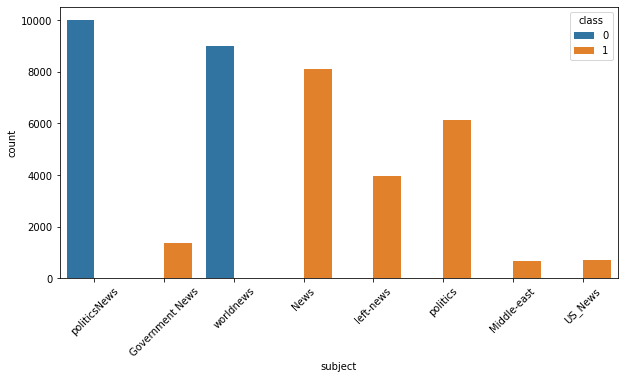

In [63]:
# Qual o tipo de notícia mais comum por assunto?
plt.figure(figsize=(10,5))
plt.xticks(rotation=45)
sns.countplot(x='subject', data=df, hue='class')

So tem *fake news*, menos nos assuntos de **noticias politicas** e do **mundo**.  
Esses documentos vao ser faceis para classificar. Parece que so com o assunto, ja da para inferir se é *fake* ou nao.

Vamos entao construir uma nova variavel concatenando o **titulo** e o **assunto** do texto. Essa nova variavel servira de input para a nossa rede neuronal. 

In [21]:
df = df.fillna('')

df["total"] = df['title'] + " " + df["subject"]

df.head()

,Id,title,text,subject,date,class,total
0,0,Trump defends tax plan as 'great Christmas gif...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"December 16, 2017",0,Trump defends tax plan as 'great Christmas gif...
1,1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",Government News,"Sep 22, 2016",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
2,2,Trump rails against press in response to repor...,"FAIRFIELD, Conn. (Reuters) - U.S. Republican D...",politicsNews,"August 14, 2016",0,Trump rails against press in response to repor...
3,3,Republican Santorum drops out of White House r...,WASHINGTON (Reuters) - Rick Santorum withdrew ...,politicsNews,"February 4, 2016",0,Republican Santorum drops out of White House r...
4,4,Immigrants in Central Florida nervous about se...,"APOPKA, Fla. (Reuters) - With Hurricane Irma b...",worldnews,"September 9, 2017",0,Immigrants in Central Florida nervous about se...


In [22]:
X = df.drop("class", axis = 1)
y = df["class"]

X.shape, y.shape

((40000, 6), (40000,))

# Preprocessamento

In [27]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [28]:
VOCAB_SIZE = 5000
MAX_LENGTH = 25
EMBEDDING_DIM = 40

text = X.copy()

- Vamos remover todos os elementos que nao sao compostos com letras, ou seja os digitos, a ponctuaçao, etc.
- Depois disso transformamos todas as letras em minuscula.
- Removemos os *stopwords*
- e reduzimos as palavras a raiz delas com o processo de *stemming*

In [29]:
def text_cleaning(length):
    ps = PorterStemmer()
    corpus = []
    for i in range(length):
        m = re.sub("[^a-zA-Z]", " ", text["total"][i])
        m = m.lower()
        m = m.split()
        m = [ps.stem(word) for word in m if not word in stopwords.words('english')]
        clean_text = " ".join(m)
        corpus.append(clean_text)
        
    return corpus

In [30]:
%%time
clean_text_corpus = text_cleaning(len(text))

CPU times: user 1min 13s, sys: 6.79 s, total: 1min 20s
Wall time: 1min 20s


In [31]:
clean_text_corpus[0]

'trump defend tax plan great christma gift middl class politicsnew'

In [32]:
# Direct mapping from token (a token can be a word or a character) to a number
# to one hot
onehot_text = [one_hot(words, VOCAB_SIZE) for words in clean_text_corpus]

In [66]:
onehot_text[0]

[3405, 3462, 2588, 3855, 1735, 1874, 3345, 231, 2037, 3935]

E deixamos todos os documentos com o mesmo tamanho.

In [33]:
# padding sequences
padded_doc = pad_sequences(onehot_text, padding="pre", maxlen=MAX_LENGTH)

Precisamos transformar os inputs em numpy para podermos utiliza-los com a rede neuronal.

In [34]:
x_train = np.array(padded_doc)
y_train = np.array(y)

# Modelo

In [35]:
def build_model():
    # model structure
    model = tf.keras.Sequential([
        L.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
        L.Dropout(0.3),
        L.LSTM(100),
        L.Dropout(0.3),
        L.Dense(64, activation = "relu"),
        L.Dropout(0.3),
        L.Dense(1, activation = "sigmoid")
    ])
    
    model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 metrics=tf.metrics.BinaryAccuracy())
    
    return model

In [36]:
news_classifier = build_model()
news_classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 40)            200000    
                                                                 
 dropout (Dropout)           (None, 25, 40)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

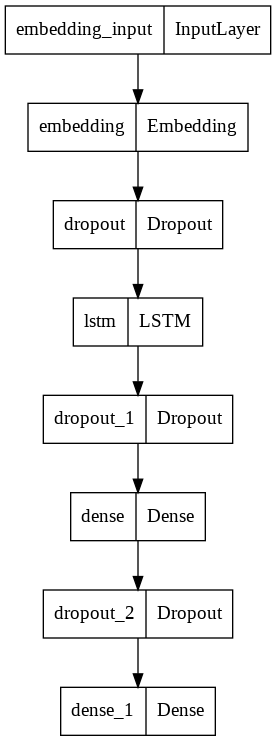

In [37]:
tf.keras.utils.plot_model(news_classifier)

# Treinamento

In [38]:
my_callbacks = [tf.keras.callbacks.ModelCheckpoint("news_classifier.h5", monitor="val_loss", save_best_only=True),
                tf.keras.callbacks.CSVLogger("training.log"),
                tf.keras.callbacks.EarlyStopping(patience=5),
                # Reduce learning rate when a metric has stopped improving:
                # factor: factor by which the learning rate will be reduced
                # patience: number of epochs with no improvement after which learning rate will be reduced
                # min_lr: lower bound on the learning rate
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
               ]

In [39]:
history = news_classifier.fit(
    x_train,
    y_train,
    epochs = 25,
    batch_size = 128,
    validation_split = 0.2,
    callbacks = my_callbacks
)

Epoch 1/25
250/250 [==============================] - 19s 66ms/step - loss: 0.0957 - binary_accuracy: 0.9780 - val_loss: 3.2695e-04 - val_binary_accuracy: 1.0000 - lr: 0.0010
Epoch 2/25
250/250 [==============================] - 16s 63ms/step - loss: 3.4799e-04 - binary_accuracy: 1.0000 - val_loss: 2.1002e-05 - val_binary_accuracy: 1.0000 - lr: 0.0010
Epoch 3/25
250/250 [==============================] - 16s 63ms/step - loss: 7.6633e-05 - binary_accuracy: 1.0000 - val_loss: 2.7218e-06 - val_binary_accuracy: 1.0000 - lr: 0.0010
Epoch 4/25
250/250 [==============================] - 16s 64ms/step - loss: 4.8766e-05 - binary_accuracy: 1.0000 - val_loss: 1.5272e-06 - val_binary_accuracy: 1.0000 - lr: 0.0010
Epoch 5/25
250/250 [==============================] - 16s 64ms/step - loss: 2.9735e-05 - binary_accuracy: 1.0000 - val_loss: 7.3143e-07 - val_binary_accuracy: 1.0000 - lr: 0.0010
Epoch 6/25
250/250 [==============================] - 16s 64ms/step - loss: 2.6526e-05 - binary_accuracy: 1.0

In [54]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

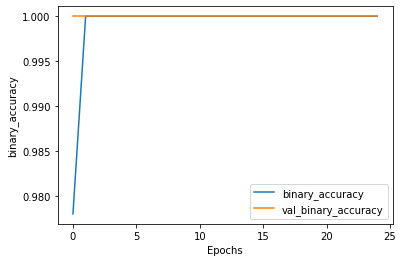

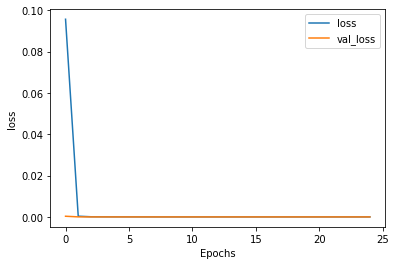

In [55]:
plot_graphs(history, "binary_accuracy")
plot_graphs(history, "loss")

# Prediçoes e gerando o arquivo de submissão

In [42]:
test_df = pd.read_csv(SOURCE_DIR + "/test.csv")

test_df.head()

,Id,title,text,subject,date
0,40000,Peru's Congress ousts cabinet as political cri...,LIMA (Reuters) - Peru s opposition-controlled ...,worldnews,"September 15, 2017"
1,40001,SICK OF THE LIES FROM CNN? You’re In Luck! Tod...,Here are a few memes to spread around:,politics,"Jul 1, 2016"
2,40002,‘Auntie’ Maxine Waters’ Showdown In Senate In...,I ll admit it: I am not a huge fan of tribute ...,News,"August 2, 2017"
3,40003,WATCH: General BOMBARDS Trump For The ‘Most A...,"As you may already know, Trump recently shocke...",News,"February 6, 2017"
4,40004,U.S. court skeptical of lawmaker immunity in t...,NEW YORK (Reuters) - A federal appeals court f...,politicsNews,"June 13, 2016"


In [43]:
test_df = test_df.fillna('')
test_df["total"] = test_df["title"] + " " + test_df["subject"]

text_test = test_df.copy()

clean_test_corpus = text_cleaning(len(text_test))

# one hot encoder
onehot_text_test = [one_hot(words, VOCAB_SIZE) for words in clean_test_corpus]

# padding sequences
padded_doc_test = pad_sequences(onehot_text_test, padding="pre", maxlen = 25)

x_test = np.array(padded_doc_test)

In [47]:
# making predictions
model_preds = news_classifier.predict(x_test)
# predictions = [int(np.round(pred[0])) for pred in predictions]

In [48]:
submission = pd.DataFrame(model_preds)
sample_sub = pd.read_csv(SOURCE_DIR + '/sample_submission.csv', index_col=0)
submission.index = sample_sub.index
submission.columns=['Predicted']
submission

,Predicted
Id,
40000,3.229817e-09
40001,1.000000e+00
40002,1.000000e+00
40003,1.000000e+00
40004,3.478495e-10
...,...
44893,1.000000e+00
44894,1.000000e+00
44895,1.000000e+00


In [51]:
# submission
submission.to_csv("submission.csv")